# Sea Surface Temperature Reconstruction under cloud occlusion

See Surface Temperature (SST) data are mostly acquired by means of satellites detecting the infrared radiation emitted from the sea surface. This radiation can be absorbed by clouds, causing large occlusions in collected observations. Filling these gaps is the task of your exam.

We focus on a region of the north adriatic sea. Data are taken from the MODIS dataset; we use the nigthly data collected by the Aqua satellite.


In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

The next cells contain instructions for downloading data.
**Please, make your own copy.**

Le us inspect and visualize data.

In [2]:
x_train_n = np.load('/kaggle/input/seatemperature/x_train_night.npy')
x_val_n = np.load('/kaggle/input/seatemperature/x_val_night.npy')
x_test_n = np.load('/kaggle/input/seatemperature/x_test_night.npy')

print(x_train_n.shape)
print(x_val_n.shape)
print(x_test_n.shape)

print(f"min train temperature: {np.nanmin(x_train_n)}")
print(f"max train temperature: {np.nanmax(x_train_n)}")
print(f"mean train temperature: {np.nanmean(x_train_n)}")
print(f"std train temperature: {np.nanstd(x_train_n)}\n")

print(f"min val temperature: {np.nanmin(x_val_n)}")
print(f"max val temperature: {np.nanmax(x_val_n)}\n")

print(f"min test temperature: {np.nanmin(x_test_n)}")
print(f"max test temperature: {np.nanmax(x_test_n)}")


(5832, 128, 128)
(1090, 128, 128)
(895, 128, 128)
min train temperature: 0.08999999612569809
max train temperature: 30.654998779296875
mean train temperature: 19.480466842651367
std train temperature: 5.093418598175049

min val temperature: 1.274999976158142
max val temperature: 29.979999542236328

min test temperature: 2.884999990463257
max test temperature: 30.594999313354492


Let us visualize a few images. Occluded area are coded with nans: they may correspond to land or clouds. nans are renderd in blank.

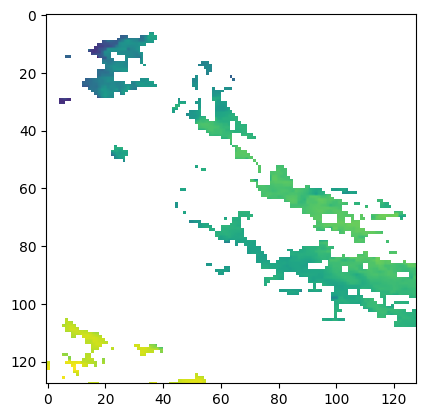

In [3]:
i = np.random.randint(0, x_train_n.shape[0])
plt.imshow(x_train_n[i]) #nans are blank; they could be land or clouds

In [4]:
dates_train_n = np.load('/kaggle/input/seatemperature/dates_train_night.npy')
dates_val_n = np.load('/kaggle/input/seatemperature/dates_val_night.npy')
dates_test_n = np.load('/kaggle/input/seatemperature/dates_test_night.npy')

print(dates_train_n.shape) # from 2002-07-04 to 2018-07-04
print(dates_val_n.shape)   # from 2018-07-04 to 2021-07-04
print(dates_test_n.shape)  # from 2021-07-04 to 2023-12-31

(5832,)
(1090,)
(895,)


We know the part of the territory corresponding to land.
In the land-sea mask, 1 is for sea, and 0 for land.

(128, 128)
sea percentage =  0.408203125


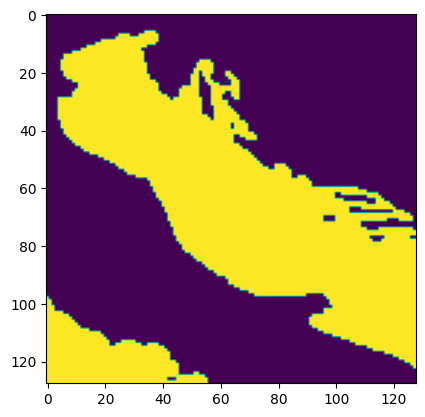

In [5]:
land_sea_mask = np.load('/kaggle/input/seatemperature/land_sea_mask.npy')
print(land_sea_mask.shape)
plt.imshow(land_sea_mask)
total_sea = np.sum(land_sea_mask)
print("sea percentage = ", total_sea/(128*128))

You can also make use of a statistical baseline, which already provides an interesting approximation. Your task is to make meaningful improvements to it.

In [6]:
baseline = np.load('/kaggle/input/seatemperature/stat_baseline.npy')
print(baseline.shape)
print(f"min baseline temperature: {np.nanmin(baseline)}")
print(f"max baseline temperature: {np.nanmax(baseline)}")

(366, 128, 128)
min baseline temperature: 0.0
max baseline temperature: 27.10306060332889


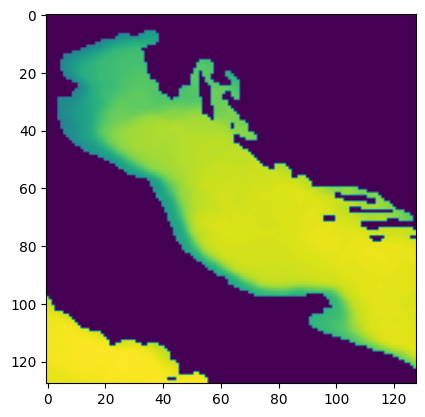

In [7]:
i = np.random.randint(0, baseline.shape[0])
plt.imshow(baseline[i]) #nans are blank; they could be land or clouds

# Normalization

We perform gaussian normalization. You may use an alternative normalization if you prefer.

In [8]:
x_train_mean = np.nanmean(x_train_n)
x_train_std = np.nanstd(x_train_n)

In [9]:
x_train_n = (x_train_n - x_train_mean) / x_train_std
x_val_n = (x_val_n - x_train_mean) / x_train_std
x_test_n = (x_test_n - x_train_mean) / x_train_std

baseline_nan = np.where(land_sea_mask,baseline,np.nan)
baseline_nan = (baseline_nan - x_train_mean) / x_train_std
baseline = np.where(land_sea_mask,baseline_nan,0.0)

# Generator

A problem with occluded data is that we do not have ground truth available, as we do not know the actual sea temperature beneath the clouds.

To address this, we create an artificial ground truth by extending the clouded region. Specifically, we superimpose the clouds from a randomly chosen different day onto a given day, providing a configurable amount of auxiliary clouds.

In [10]:
def generator(batch_size, dataset, dates):
    size = 128
    while True:
        batch_x = np.zeros((batch_size, size, size, 4))
        batch_y = np.zeros((batch_size, size, size, 3))

        for b in range(batch_size):
            # Choose an image with a sufficiently large area of visible sea
            found = False
            while not found:
              i = np.random.randint(0, dataset.shape[0])
              visible = np.sum(~np.isnan(dataset[i])/total_sea)
              if visible > 0.4:
                found = True
            image_current = np.nan_to_num(dataset[i], nan=0)
            mask_current = np.isnan(dataset[i])

            # Extending clouds

            found = False
            while not found:
              r = np.random.randint(0, dataset.shape[0])
              mask_r = np.isnan(dataset[r])
              mask_or_r = np.logical_or(mask_current, mask_r)
              nnans = np.sum(~mask_or_r)/total_sea
              if nnans > 0.05 and nnans < min(visible-.1,0.4):
                found = True

            artificial_mask_current = ~mask_or_r  #1 visible, 0 masked

            # Apply the enlarged mask to the current day's image
            image_masked_current = np.where(artificial_mask_current, image_current, 0)

            # we tune the statistical baseline according to the average sea temperature of the current day

            # convert the current date to a datetime object using pandas
            date_series = pd.to_datetime(dates[i], unit='D', origin='unix')
            day_of_year = date_series.dayofyear

            #avg temp of the current day
            image_masked_nan = np.where(artificial_mask_current, image_current, np.nan)

            avg_temp_real = np.nanmean(image_masked_nan)
            avg_temp_baseline = np.nanmean(np.where(artificial_mask_current,baseline[day_of_year - 1],np.nan))
            tuned_baseline = baseline[day_of_year - 1] + avg_temp_real - avg_temp_baseline  # Adjust the baseline to match the average temperature of the current day
            tuned_baseline = np.where(land_sea_mask,tuned_baseline,.0)


            # Removing nans for usage in neural networks

            mask_current = np.logical_not(mask_current) # 1 for clear sea, 0 for land/clouds
            diff_mask = np.logical_and(~artificial_mask_current,mask_current) # 1 for clear sea, 0 for land/clouds and artificial clo

            # Create batch_x and batch_y
            batch_x[b, ..., 0] = image_masked_current            #current artificially clouded image
            batch_x[b, ..., 1] = artificial_mask_current         #current artificial mask
            batch_x[b, ..., 2] = land_sea_mask                   #land-sea mask
            batch_x[b, ..., 3] = tuned_baseline                  #tuned baseline

            batch_y[b, ..., 0] = image_current                   #real image
            batch_y[b, ..., 1] = mask_current                    #real mask
            batch_y[b, ..., 2] = diff_mask                       #artificial mask used for the input

        yield batch_x, batch_y

In [11]:
batch_size = 32

train_gen = generator(batch_size, x_train_n, dates_train_n)
val_gen = generator(batch_size, x_val_n, dates_val_n)
test_gen = generator(batch_size, x_test_n, dates_test_n)

The generator returns two sets of data, called batch_x and batch_y. The idea is that batch_x data are possible inputs for the neural network, while batch_y data provide ground_truth information that can be used for defining the loss function, or auxiliary metrics. Let us inspect them in more detail.

In [12]:
import matplotlib.pyplot as plt

def plot_elements(images, titles):

  num_of_images = len(images)
  rows = 1
  cols = num_of_images
  mini = np.nanmin(np.array(images))
  maxi = np.nanmax(np.array(images))
  print(mini,maxi)

  plt.figure(figsize=(10, 10*num_of_images))
  for i in range(num_of_images):
    print(f"image {i}; {np.min(images[i])}, {np.max(images[i])}")
    plt.subplot(rows, cols, i+1)
    plt.imshow(images[i],vmin=mini,vmax=maxi)
    plt.axis('off')
    plt.title(titles[i])
  plt.show()

0.0 17.569999670054884
image 0; 0.0, 17.569999670054884
image 1; 0.0, 17.569999670054884
image 2; 0.0, 16.945382002610707


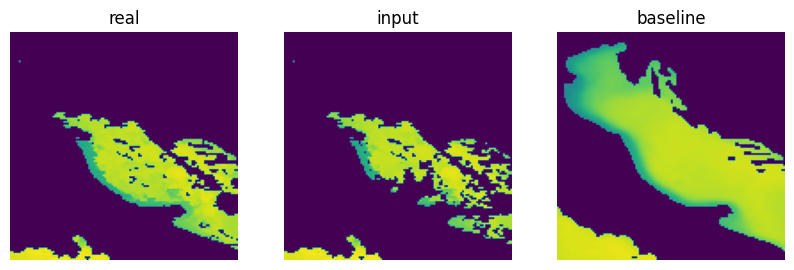

0.0 1.0
image 0; 0.0, 1.0
image 1; 0.0, 1.0
image 2; 0.0, 1.0


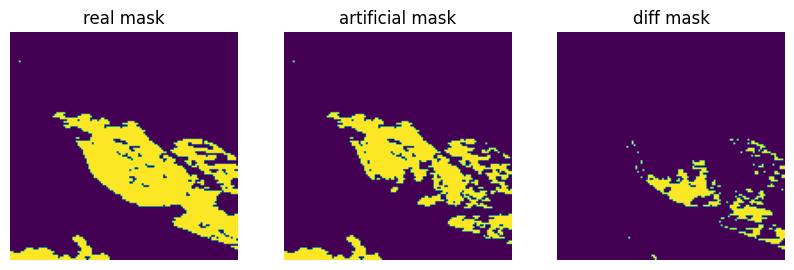

In [13]:
batch_x, batch_y = next(test_gen)
assert(np.sum(np.isnan(batch_x))==0)
assert(np.sum(np.isnan(batch_y))==0)
real_denorm = np.where(batch_y[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0)
artificial_denorm = np.where(batch_x[0,...,1],batch_y[0,...,0]*x_train_std + x_train_mean,0.0)
baseline_denorm = np.where(land_sea_mask,batch_x[0,...,3]*x_train_std + x_train_mean,0.0)

plot_elements([real_denorm, artificial_denorm, baseline_denorm], ['real', 'input','baseline'])
plot_elements([batch_y[0,...,1], batch_x[0,...,1], batch_y[0,...,2]],["real mask","artificial mask","diff mask"])

In the first row, we see:
- the real image of the day
- the input passed to the model, that is a masked version of the previous image
- the tentative reconstruction done via the statistical baseline
All images have been denormalized.

In the second row we see:
- the mask of the current day
- the enlarged masked with addiitonal clouds
- the difference, showing the portion of the image visible in the first one, but occluded in the second. This is the region where the performance of the model must be evaluated


# U-Net MODEL

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, BatchNormalization, ReLU, Add, Activation, Multiply, UpSampling2D
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Conv2D, Reshape, Multiply, Add, Activation, Lambda, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import numpy as np

## CBAM Block (Convolutional Block Attention Module)

In the paper [**"Reconstruction of Subsurface Temperature Field in the South China Sea From Satellite Observations Based on an Attention U-Net Model"**](https://ieeexplore.ieee.org/abstract/document/9863856?casa_token=I79nNn-ZzvMAAAAA:y6lukwKdmw8nt6ZQO13JGvT3qQRaABeQULJXsuDImXtYjoxugOzSD3B9C0A42Ih322-qzuTRTg), the authors discuss attention mechanisms in convolutional neural networks (CNNs), specifically in Section III titled "Attention U-Net Model for ST Reconstruction." The authors highlight how integrating attention modules, like the Convolutional Block Attention Module (CBAM), can enhance the accuracy of image classification or geophysical parameter estimation. Among the various attention mechanisms, they chose CBAM because it applies attention both across the channel and spatial dimensions, allowing the model to focus on "what" and "where" to attend to, improving performance in these areas.

In my project, I implemented a Convolutional Block Attention Module (CBAM) to improve feature selection in the U-Net model. CBAM enhances the network's ability to focus on important features by applying attention mechanisms in both the channel and spatial dimensions. The CBAM block operates in two main stages: Channel Attention and Spatial Attention.

1. Channel Attention
The purpose of channel attention is to identify which feature maps (channels) are the most important. This is done by calculating the importance of each channel using two types of pooling: Global Average Pooling and Global Max Pooling. These methods capture the average and maximum activations across spatial dimensions.

2. Spatial Attention
Once the channels are refined, spatial attention is used to focus on the most important regions within the feature maps. Spatial attention highlights "where" the important information is located.



In [15]:
def cbam_block(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    
    # Channel Attention
    avg_pool = GlobalAveragePooling2D()(input_feature)
    max_pool = GlobalMaxPooling2D()(input_feature)
    
    avg_pool = Reshape((1, 1, channel))(avg_pool)
    max_pool = Reshape((1, 1, channel))(max_pool)
    
    shared_layer_one = Dense(channel//ratio, activation='relu', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    shared_layer_two = Dense(channel, activation='linear', kernel_initializer='he_normal', use_bias=True, bias_initializer='zeros')
    
    avg_pool = shared_layer_two(shared_layer_one(avg_pool))
    max_pool = shared_layer_two(shared_layer_one(max_pool))
    
    channel_attention = Add()([avg_pool, max_pool])
    channel_attention = Activation('sigmoid')(channel_attention)
    
    channel_refined_feature = Multiply()([input_feature, channel_attention])
    
    # Spatial Attention
    avg_pool_spatial = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(channel_refined_feature)
    max_pool_spatial = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(channel_refined_feature)
    concat = Concatenate(axis=-1)([avg_pool_spatial, max_pool_spatial])
    
    spatial_attention = Conv2D(1, (7, 7), activation='sigmoid', padding='same', kernel_initializer='he_normal', use_bias=False)(concat)
    
    refined_feature = Multiply()([channel_refined_feature, spatial_attention])
    
    return refined_feature

In the paper [**"Spatiotemporal Prediction of Monthly Sea Subsurface Temperature Fields Using a 3D U-Net-Based Model"**](https://www.mdpi.com/2072-4292/14/19/4890), the authors employ a 3D U-Net model to forecast sea subsurface temperature (SSbT) fields in the Pacific Ocean and adjacent seas. The model leverages SSbT data from the previous 12 months to predict monthly SSbT fields, providing forecasts for up to 12 months into the future.

In the paper [**"Reconstruction of Subsurface Temperature Field in the South China Sea From Satellite Observations Based on an Attention U-Net Model"**](https://ieeexplore.ieee.org/abstract/document/9863856?casa_token=I79nNn-ZzvMAAAAA:y6lukwKdmw8nt6ZQO13JGvT3qQRaABeQULJXsuDImXtYjoxugOzSD3B9C0A42Ih322-qzuTRTg), the authors present an Attention U-Net model designed for reconstructing subsurface temperature (ST) in the South China Sea. This model leverages satellite observations of various surface parameters, including Surface Temperature, Sea Level Anomaly and Wind Speed.
The Attention U-Net variant improves the U-Net architecture by incorporating attention mechanisms, which help the model focus on the most relevant features in the satellite data, enhancing the accuracy of subsurface temperature reconstruction.



In [16]:
# Funzione per costruire il percorso di codifica
def encoder_block(x, filters):
    # Convolutions
    conv = Conv2D(filters, (3, 3), padding='same')(x)
    conv = BatchNormalization()(conv)
    conv = ReLU()(conv)
    conv = Conv2D(filters, (3, 3), padding='same')(conv)
    conv = BatchNormalization()(conv)
    conv = ReLU()(conv)
    # CBAM
    conv = cbam_block(conv)
    # Pooling
    conv = MaxPooling2D(pool_size=(2, 2))(conv)
    return conv

# Funzione per costruire il percorso di decodifica
def decoder_block(x, skip_connection, filters, inter_channel):
    # Upsampling
    up = Conv2DTranspose(filters, (1, 1), strides=(2, 2), padding='same')(x)
    att = UpSampling2D(size=(2, 2))(skip_connection)
    up = Concatenate()([up, att])
    # CBAM
    up = cbam_block(up)
    # Convolutions
    conv = Conv2D(filters, (3, 3), padding='same')(up)
    conv = BatchNormalization()(conv)
    conv = ReLU()(conv)
    conv = Conv2D(filters, (3, 3), padding='same')(conv)
    conv = BatchNormalization()(conv)
    conv = ReLU()(conv)
    return conv


## U-Shaped Structure:

The U-Net has a symmetric U-shaped structure, consisting of two main paths: a contracting path (encoding path) and an expansive path (decoding path).

### Encoding Path:
This path includes a series of convolutional blocks that progressively reduce the spatial dimensions of the image while increasing the number of channels (feature maps). Each block consists of two convolutions, batch normalization, and an activation function (typically ReLU).

### Bottleneck:
Located at the base of the U, the bottleneck has the smallest spatial dimensions and contains the highest number of channels. This level captures the most abstract features of the image.

### Decoding Path:
This path uses upsampling operations to increase the spatial dimensions of the image. The upsampled results are concatenated with the corresponding feature maps from the encoding path through skip connections. This helps preserve detailed spatial information during the upsampling process.

### Output Layer:
At the end of the decoding path, a 1x1 convolution reduces the number of channels to produce the final segmentation map, which can be a probability map for each pixel class.

In [17]:
def improved_unet_2d(input_shape):
    inputs = Input(input_shape)

    # Encoder path
    conv1 = encoder_block(inputs, 64)
    conv2 = encoder_block(conv1, 128)
    conv3 = encoder_block(conv2, 256)

    # Bottleneck with CBAM
    conv4 = Conv2D(512, (3, 3), padding='same')(conv3)
    conv4 = BatchNormalization()(conv4)
    conv4 = ReLU()(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = ReLU()(conv4)
    conv4 = cbam_block(conv4) # CBAM
    
    # Decoder with Custom Attention Block
    conv5 = decoder_block(conv4, conv3, 256, 128)
    conv6 = decoder_block(conv5, conv2, 128, 64)
    conv7 = decoder_block(conv6, conv1, 64, 32)

    # Output layer
    outputs = Conv2D(1, (1, 1), activation='linear')(conv7)

    model = Model(inputs, outputs)
    return model

The custom_mae function calculates the Masked Mean Absolute Error (MAE). This custom loss function is designed to evaluate the performance of a model by focusing on specific parts of the input data, as defined by a mask to avoid measurement in some invalid or missing values.

In [18]:
def custom_mae(y_true, y_pred):

    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    mask = y_true[..., 2]
    y_true_temp = y_true[..., 0]
    y_pred_temp = y_pred[..., 0]
    
    # Calculate absolute errors
    absolute_errors = tf.abs(y_true_temp - y_pred_temp)
    masked_absolute_errors = tf.multiply(absolute_errors, mask)

    mae = tf.reduce_sum(masked_absolute_errors) / (tf.reduce_sum(mask) + tf.keras.backend.epsilon())
    return mae

The custom_weighted_loss function computes a custom loss that applies different weights based on the magnitude of the prediction error, with additional consideration for specific regions of interest defined by a mask. This loss function is useful for emphasizing errors in certain areas and handling regions with varying importance.

In [19]:
def custom_weighted_loss(y_true, y_pred, smoothing=0.1):
    # y_true -- true labels, expected to contain a mask in the third channel
    # y_pred -- predicted labels
    # smoothing -- small value added to thresholds to smooth transitions between weighted errors

    mask = y_true[..., 2]
    y_true_temp = y_true[..., 0]
    y_pred_temp = y_pred[..., 0]
    
    abs_diff = tf.abs(y_true_temp - y_pred_temp)    
    weights = tf.where(abs_diff > (1.0 + smoothing), 2.0, 1.0)
    
    # Apply the mask and compute the weighted squared difference
    weighted_squared_diff = tf.square(abs_diff) * weights * mask
    
    # Normalize by the sum of the mask
    return tf.reduce_sum(weighted_squared_diff) / (tf.reduce_sum(mask) + tf.keras.backend.epsilon())

In [20]:
# Print of available GPU's for multithreading
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


Found out that distributed training is slower than single gpu on Kaggle. If you run it in a different environment you can use following code to mirroring the work on the gpu's when compiling the model.
    
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():

In [21]:
def compile_improved_unet_2d():
    
    model = improved_unet_2d(input_shape=(128, 128, 4))
    model.compile(optimizer=Adam(learning_rate=5e-4), 
                  loss=custom_weighted_loss,
                  metrics=[custom_mae])
    return model

model = compile_improved_unet_2d()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      2,368 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ re_lu[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ re_lu_1[0][0]     │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 64)        │          0 │ re_lu_1[0][0]     │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1, 64)  │          0 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1, 1, 64)  │          0 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1, 1, 8)   │        520 │ reshape[0][0],    │
│                     │                   │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1, 1, 64)  │        576 │ dense[0][0],      │
│                     │                   │            │ dense[1][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 1, 64)  │          0 │ dense_1[0][0],    │
│                     │                   │            │ dense_1[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1, 1, 64)  │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 128, 128,  │          0 │ re_lu_1[0][0],    │
│                     │ 64)               │            │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128, 128,  │          0 │ multiply[0][0]    │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 7,368,919 (28.11 MB)

 Trainable params: 7,363,287 (28.09 MB)

 Non-trainable params: 5,632 (22.00 KB)

## Callbacks Description

The **ReduceLROnPlateau** callback is designed to adjust the learning rate dynamically based on the validation custom MAE. It monitors this metric and reduces the learning rate by a factor of 0.5 when no significant improvement is observed over a set number of epochs, specified by the patience parameter (set to 4 epochs)

The **EarlyStopping** callback is utilized to avoid overfitting and to optimize computational resources. It monitors the validation custom MAE and halts training if no improvement is detected over a specified number of epochs, defined by the patience parameter (set to 12 epochs). By enabling the *restore_best_weights** option, the callback ensures that the model weights from the epoch with the best performance are retained, resulting in the most effective model state at the end of training. 

In [22]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_custom_mae', factor=0.5, patience=6, min_lr=1e-10, verbose=1)
early_stopping = EarlyStopping(monitor='val_custom_mae', mode='min', patience=35, restore_best_weights=True, verbose=1)

# Callbacks for debugging and analisys
#checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
#tensorboard = TensorBoard(log_dir="/kaggle/working/logs", histogram_freq=1)

In [23]:
history = model.fit(train_gen, 
                    validation_data=val_gen, 
                    epochs=250, 
                    steps_per_epoch=180,
                    validation_steps=50, 
                    callbacks=[early_stopping, reduce_lr], 
                    verbose=1)

Epoch 1/250


I0000 00:00:1725957101.183661      69 service.cc:145] XLA service 0x7f7df8002e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725957101.183720      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1725957125.044927      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


180/180 ━━━━━━━━━━━━━━━━━━━━ 78s 218ms/step - custom_mae: 0.2567 - loss: 0.2952 - val_custom_mae: 0.6311 - val_loss: 0.6079 - learning_rate: 5.0000e-04
Epoch 2/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 36s 202ms/step - custom_mae: 0.1296 - loss: 0.0295 - val_custom_mae: 0.2182 - val_loss: 0.0775 - learning_rate: 5.0000e-04
Epoch 3/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 36s 202ms/step - custom_mae: 0.1242 - loss: 0.0271 - val_custom_mae: 0.1064 - val_loss: 0.0197 - learning_rate: 5.0000e-04
Epoch 4/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 36s 202ms/step - custom_mae: 0.1155 - loss: 0.0235 - val_custom_mae: 0.1081 - val_loss: 0.0205 - learning_rate: 5.0000e-04
Epoch 5/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 36s 202ms/step - custom_mae: 0.1187 - loss: 0.0246 - val_custom_mae: 0.0989 - val_loss: 0.0176 - learning_rate: 5.0000e-04
Epoch 6/250
180/180 ━━━━━━━━━━━━━━━━━━━━ 36s 202ms/step - custom_mae: 0.1089 - loss: 0.0211 - val_custom_mae: 0.0962 - val_loss: 0.0171 - learning_rate: 5.0000e-04
Epoch 7/250
180/180 ━━━━━━━━

# Evaluation

The model must be evaluted by means of the following function, calling the test generator 50 times. The metrics adopted is the Rooted Mean Squared Error (RMSE).

To make a running example, we measure the performance of the statistical
baseline.

In [24]:
# Initialize lists to store the errors and the maximum errors
RMSE = []

# Generate and evaluate tot batches
tot = 50
for _ in range(tot):
    # Generate a batch
    batch_x, batch_y = next(test_gen)
    #uncomment the next line and call your model
    predictions = model.predict(batch_x, verbose=0)[...,0]
    #predictions = batch_x[...,3] #use the baseline as prediction

    # Denormalize data !!!
    predictions_denorm = predictions*x_train_std + x_train_mean
    true_values_denorm = batch_y[..., 0]*x_train_std + x_train_mean

    # Get the masks and calculate the errors
    diffMask = batch_y[..., 2]
    diff_errors_batch = np.where(diffMask, np.abs(predictions_denorm - true_values_denorm), np.nan)
    squared_errors = np.nanmean(diff_errors_batch**2,axis=(1,2))
    RMSE.append(np.sqrt(squared_errors))

RMSE = np.concatenate(RMSE)

print(f"RMSE :", np.mean(RMSE))
print(f"RMSE std :", np.std(RMSE))

RMSE : 0.46999031913215417
RMSE std : 0.14396310896078615


# Remarks

All data in batch_x can be used as input to the model. You may choose to use only a subset of the data or perform additional preprocessing if desired.

Do not modify the test generator, as this could affect the evaluation of the model.

The notebook should include the code for a single model. You may discuss additional experiments by briefly mentioning the results.

The project must be written in tensorflow, as usual.